In [14]:
import os
import glob
import shutil

def clear_folder_make_ess_pv(folder_path):
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)
    os.makedirs(os.path.join(folder_path,'ess'))
    os.makedirs(os.path.join(folder_path,'pv'))

folder_path = 'plots'
clear_folder_make_ess_pv(folder_path)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from EnergySystem import EnergySystem
from config import pv_config, grid_config, ess_config


In [16]:
import json

print("Version 0.0.2")

with open('config.json', 'r') as f:
    js_data = json.load(f)

data = pd.read_csv('combined_data.csv')
time_interval = js_data["time_interval"]["numerator"] / js_data["time_interval"]["denominator"]

pv_loss = js_data["pv"]["loss"]
pv_cost_per_kW = js_data["pv"]["cost_per_kW"]
pv_lifetime = js_data["pv"]["lifetime"]

ess_loss = js_data["ess"]["loss"]
ess_cost_per_kW = js_data["ess"]["cost_per_kW"]
ess_lifetime = js_data["ess"]["lifetime"]

grid_loss = js_data["grid"]["loss"]
sell_price = js_data["grid"]["sell_price"] #kWh
grid_capacity = js_data["grid"]["capacity"] #kWh

pv_begin = js_data["pv_capacities"]["begin"]
pv_end = js_data["pv_capacities"]["end"]
pv_groups = js_data["pv_capacities"]["groups"]

ess_begin = js_data["ess_capacities"]["begin"]
ess_end = js_data["ess_capacities"]["end"]
ess_groups = js_data["ess_capacities"]["groups"]

annot_unmet = js_data["annotated"]["unmet_prob"]
annot_benefit = js_data["annotated"]["benefit"]
annot_cost = js_data["annotated"]["cost"]

title_unmet = js_data["plot_title"]["unmet_prob"]
title_cost = js_data["plot_title"]["cost"]
title_benefit = js_data["plot_title"]["benefit"]

figure_size = (js_data["figure_size"]["length"], js_data["figure_size"]["height"])

pv_capacities = np.linspace(pv_begin, pv_end, pv_groups)
ess_capacities = np.linspace(ess_begin, ess_end, ess_groups)
results = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
affords = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
costs = pd.DataFrame(index=pv_capacities, columns= ess_capacities)
overload_cnt = pd.DataFrame(index=pv_capacities, columns= ess_capacities)


In [17]:
hour_demand = []
for index, row in data.iterrows():
    time = row['time']
    demand = row['demand']
    if time.endswith('00'):
        hour_demand.append(demand)
plt.figure(figsize=(10,8))
plt.plot(hour_demand)
plt.ylabel('Demand Power / kW')
plt.savefig('plots/demand.png')
plt.close()

In [18]:
def cal_profit(es: EnergySystem, saved_money):
    profit = saved_money - es.ess.get_cost_per_year() - es.pv.get_cost_per_year()
    return profit

In [24]:
for ess_capacity in ess_capacities:
    print(f"ess_capacity:{ess_capacity}")
    for pv_capacity in pv_capacities:
        print(f"pv_capacity:{ess_capacity}")
        pv = pv_config(capacity=pv_capacity, 
                        cost_per_kW=pv_cost_per_kW,
                        lifetime=pv_lifetime, 
                        loss=pv_loss)
        ess = ess_config(capacity=ess_capacity, 
                            cost_per_kW=ess_cost_per_kW, 
                            lifetime=ess_lifetime, 
                            loss=ess_loss,
                            charge_power=ess_capacity,
                            discharge_power=ess_capacity)
        grid = grid_config(capacity=grid_capacity, 
                            grid_loss=grid_loss,
                            sell_price= sell_price)
        energySystem = EnergySystem(pv_type=pv, 
                                    ess_type=ess, 
                                    grid_type= grid)
        benefit = energySystem.simulate(data, time_interval)
        results.loc[pv_capacity,ess_capacity] = cal_profit(energySystem, benefit)
        affords.loc[pv_capacity,ess_capacity] = energySystem.afford
        overload_cnt.loc[pv_capacity,ess_capacity] = energySystem.overload_cnt
        costs.loc[pv_capacity,ess_capacity] = energySystem.ess.capacity * energySystem.ess.cost_per_kW + energySystem.pv.capacity * energySystem.pv.cost_per_kW
        pv_generated = energySystem.day_generated
        ess_generated = energySystem.hour_stored
        ess_generated_2 = energySystem.hour_stored_2
    plt.figure(figsize=(10,8));
    plt.plot(ess_generated)
    plt.xlabel('day #')
    plt.ylabel('SoC %')
    plt.title(f'14:00 ESS SoC \n PV cap:{pv_capacity}, ESS cap:{ess_capacity}')
    plt.savefig(f'plots/ess/1400-{pv_capacity}-{ess_capacity}.png')
    plt.close()
    plt.figure(figsize=(10,8));
    plt.plot(ess_generated_2)
    plt.xlabel('day #')
    plt.ylabel('SoC%')
    plt.title(f'08:00 ESS SoC \n PV cap:{pv_capacity}, ESS cap:{ess_capacity}')
    plt.savefig(f'plots/ess/0800-{pv_capacity}-{ess_capacity}.png')
    plt.close()
        # print(energySystem.unmet)
        # spring_week_start = energySystem.season_start
        # spring_week_end = spring_week_start + energySystem.week_length
        # summer_week_start = energySystem.season_start + 1 * energySystem.season_step
        # summer_week_end = summer_week_start + energySystem.week_length
        # autumn_week_start = energySystem.season_start + 2 * energySystem.season_step
        # autumn_week_end = autumn_week_start + energySystem.week_length
        # winter_week_start = energySystem.season_start + 3 * energySystem.season_step
        # winter_week_end = winter_week_start+ energySystem.week_length

        # spring_consume_data = []
        # summer_consume_data = []
        # autumn_consume_data = []
        # winter_consume_data = []
        # for index, row in data.iterrows():
            # if index in range(spring_week_start, spring_week_end):
                # spring_consume_data.append(row['demand'])
        #     elif index in range(summer_week_start, summer_week_end):
        #         summer_consume_data.append(row['demand'])
        #     elif index in range(autumn_week_start, autumn_week_end):
        #         autumn_consume_data.append(row['demand'])
        #     elif index in range(winter_week_start, winter_week_end):
        #         winter_consume_data.append(row['demand'])

        # spring_week_time = list(range(spring_week_start, spring_week_end))
        # summer_week_time = list(range(summer_week_start, summer_week_end))
        # autumn_week_time = list(range(autumn_week_start, autumn_week_end))
        # winter_week_time = list(range(winter_week_start, winter_week_end))

        # spring_pv_generated = energySystem.spring_week_gen
        # summer_pv_generated = energySystem.summer_week_gen
        # autumn_pv_generated = energySystem.autumn_week_gen
        # winter_pv_generated = energySystem.winter_week_gen

        # spring_soc = energySystem.spring_week_soc
        # summer_soc = energySystem.summer_week_soc
        # autumn_soc = energySystem.autumn_week_soc
        # winter_soc = energySystem.winter_week_soc


        # fig, ax1 = plt.subplots()

        # plt.plot(spring_week_time, spring_pv_generated, label = 'pv generation')
        # plt.plot(spring_week_time, spring_consume_data, label = 'factory consume')
        # plt.ylabel('Power / kW')
        # plt.xlabel('15 min #')
        # plt.title(f'ess: {energySystem.ess.capacity/1000 } MWh pv: {energySystem.pv.capacity/1000 } MW spring week generate condition')
        # plt.legend()
        # plt.savefig(f'plots/{energySystem.ess.capacity}-{energySystem.pv.capacity}-spring.png')
        # plt.close()

        # plt.plot(summer_week_time, summer_pv_generated, label = 'pv generation')
        # plt.plot(summer_week_time, summer_consume_data, label = 'factory consume')
        # plt.ylabel('Power / kW')
        # plt.xlabel('15 min #')
        # plt.title(f'ess: {energySystem.ess.capacity/1000 } MWh pv: {energySystem.pv.capacity/1000 } MW summer week generate condition')
        # plt.legend()
        # plt.savefig(f'plots/{energySystem.ess.capacity}-{energySystem.pv.capacity}-summer.png')
        # plt.close()

        # plt.plot(autumn_week_time, autumn_pv_generated, label = 'pv generation')
        # plt.plot(autumn_week_time, autumn_consume_data, label = 'factory consume')
        # plt.ylabel('Power / kW')
        # plt.xlabel('15 min #')
        # plt.title(f'ess: {energySystem.ess.capacity/1000 } MWh pv: {energySystem.pv.capacity/1000 } MW autumn week generate condition')
        # plt.legend()
        # plt.savefig(f'plots/{energySystem.ess.capacity}-{energySystem.pv.capacity}-autumn.png')
        # plt.close()

        # plt.plot(winter_week_time, winter_pv_generated, label = 'pv generation')
        # plt.plot(winter_week_time, winter_consume_data, label = 'factory consume')
        # plt.ylabel('Power / kW')
        # plt.xlabel('15 min #')
        # plt.title(f'ess: {energySystem.ess.capacity/1000 } MWh pv: {energySystem.pv.capacity/1000 } MW winter week generate condition')
        # plt.legend()
        # plt.savefig(f'plots/{energySystem.ess.capacity}-{energySystem.pv.capacity}-winter.png')
        # plt.close()

    # plt.figure();
    # plt.plot(pv_generated)
    # plt.xlabel('day #')
    # plt.ylabel('Electricity kWh')
    # plt.title(f'PV generated pv cap:{pv_capacity}, ess cap:{ess_capacity}')
    # plt.savefig(f'plots/pv/{pv_capacity}-{ess_capacity}.png')
    # plt.close()


        # plt.show()


        

# results = results.astype(float)


# pv = pv_config(capacity=100000,cost_per_kW=200,lifetime=25,loss=0.95)
# ess = ess_config(capacity=100000,cost_per_kW=300,lifetime=25,loss=0.95,charge_power=100000,discharge_power=100000)
# grid = grid_config(price_schedule=price_schedule, capacity=5000, grid_loss=0.95, sell_price=0.4)
# grid = grid_config(capacity=50000, grid_loss=0.95, sell_price=0.4)


    # print(benefit)


ess_capacity:5000.0
pv_capacity:5000.0
pv_capacity:5000.0
pv_capacity:5000.0
ess_capacity:27500.0
pv_capacity:27500.0
pv_capacity:27500.0
pv_capacity:27500.0
ess_capacity:50000.0
pv_capacity:50000.0
pv_capacity:50000.0
pv_capacity:50000.0


In [20]:
def save_data(data, filename):
    data.to_csv(filename+'.csv')
    data.to_json(filename + '.json')

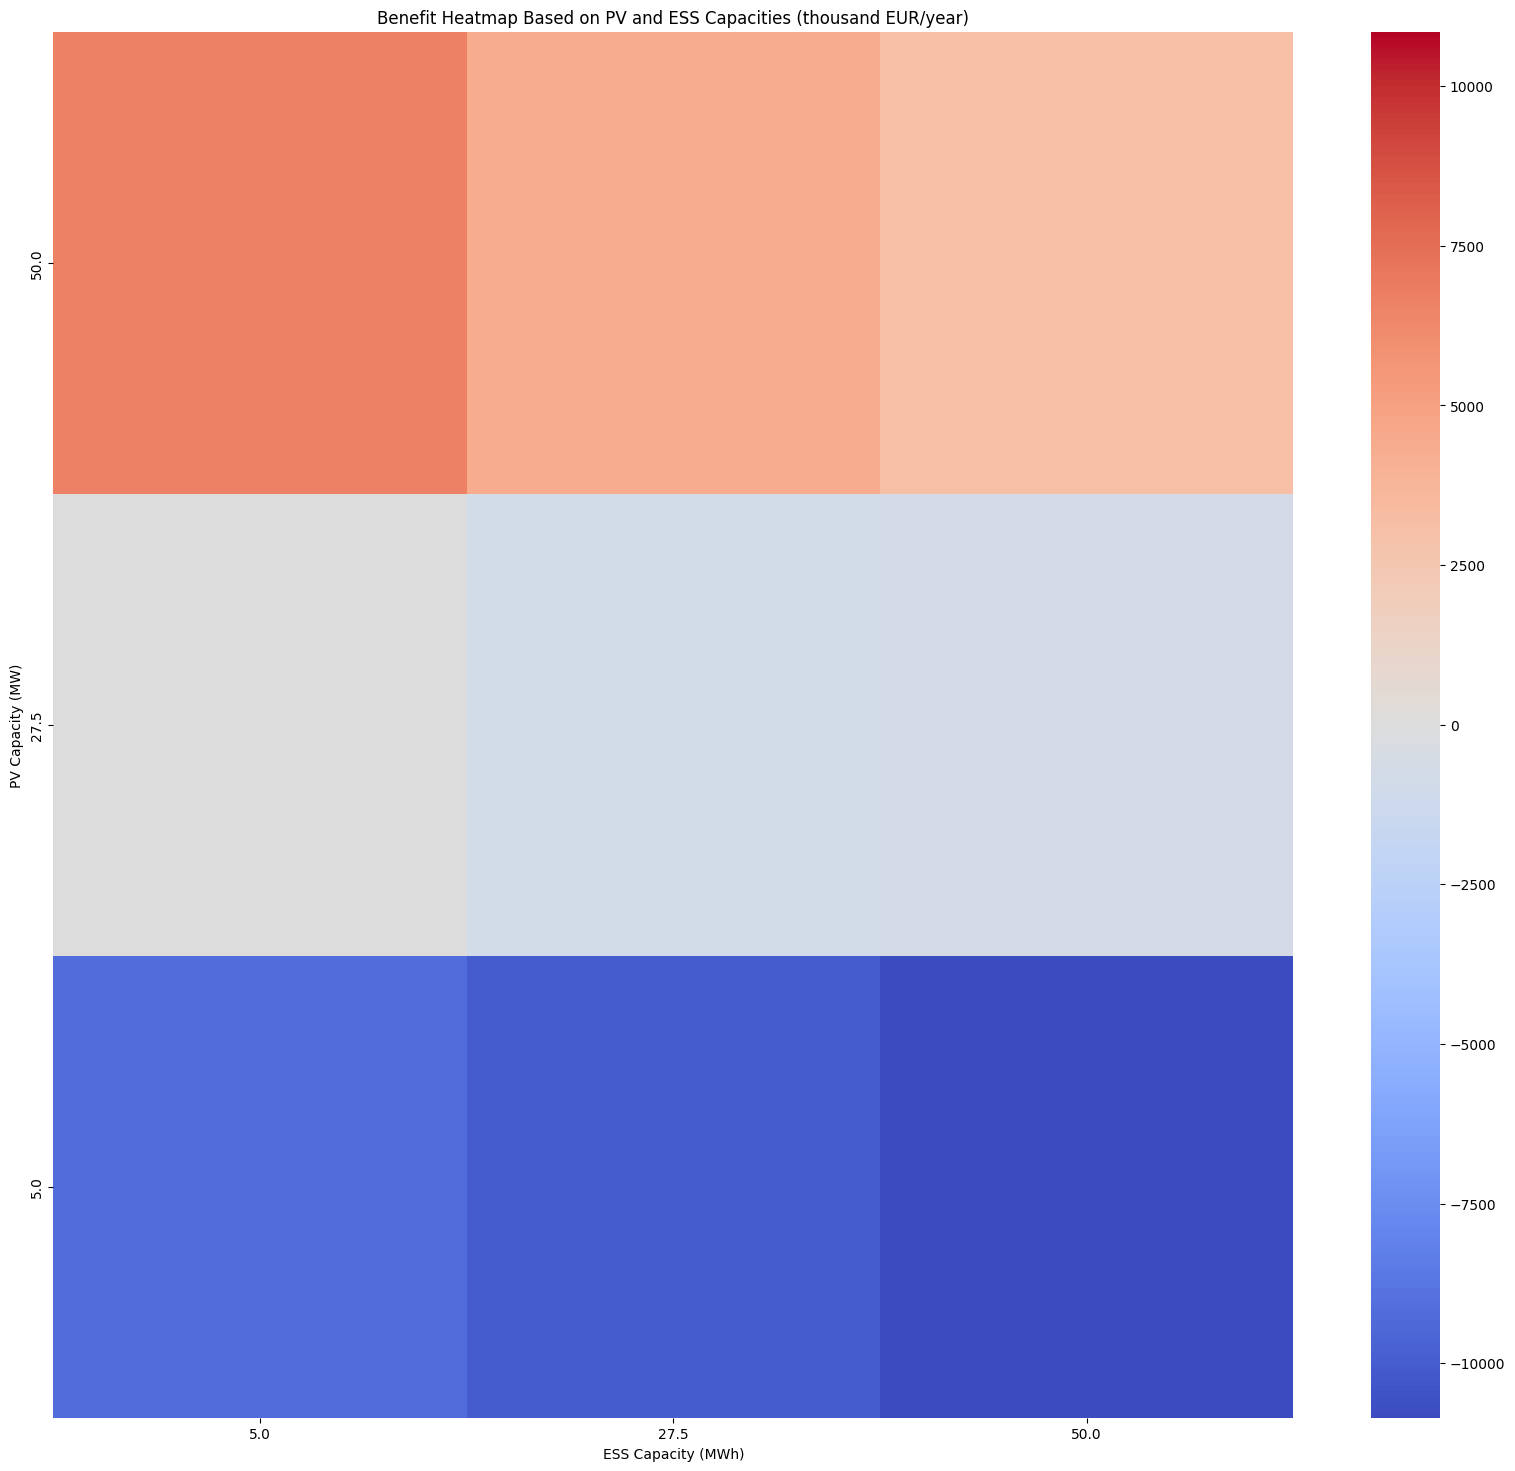

In [21]:
import matplotlib.ticker as ticker

if not os.path.isdir('data'):
    os.makedirs('data')

save_data(results, f'data/{pv_begin}-{pv_end}-{pv_groups}-{ess_begin}-{ess_end}-{ess_groups}-results')
save_data(costs, f'data/{pv_begin}-{pv_end}-{pv_groups}-{ess_begin}-{ess_end}-{ess_groups}-costs')
save_data(overload_cnt, f'data/{pv_begin}-{pv_end}-{pv_groups}-{ess_begin}-{ess_end}-{ess_groups}-overload_cnt')
df=results
df = df.astype(float)
df.index = df.index / 1000
df.columns = df.columns / 1000
min_value = df.min().min()
max_value = df.max().max()
max_scale = max(abs(min_value/1000), abs(max_value/1000))
plt.figure(figsize=figure_size)
cmap = sns.color_palette("coolwarm", as_cmap=True)
ax = sns.heatmap(df/1000, fmt=".1f", cmap=cmap, vmin=-max_scale, vmax=max_scale, annot=annot_benefit)
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.title(title_benefit)
plt.gca().invert_yaxis()
plt.xlabel('ESS Capacity (MWh)')
plt.ylabel('PV Capacity (MW)')
plt.savefig('plots/benefit.png')

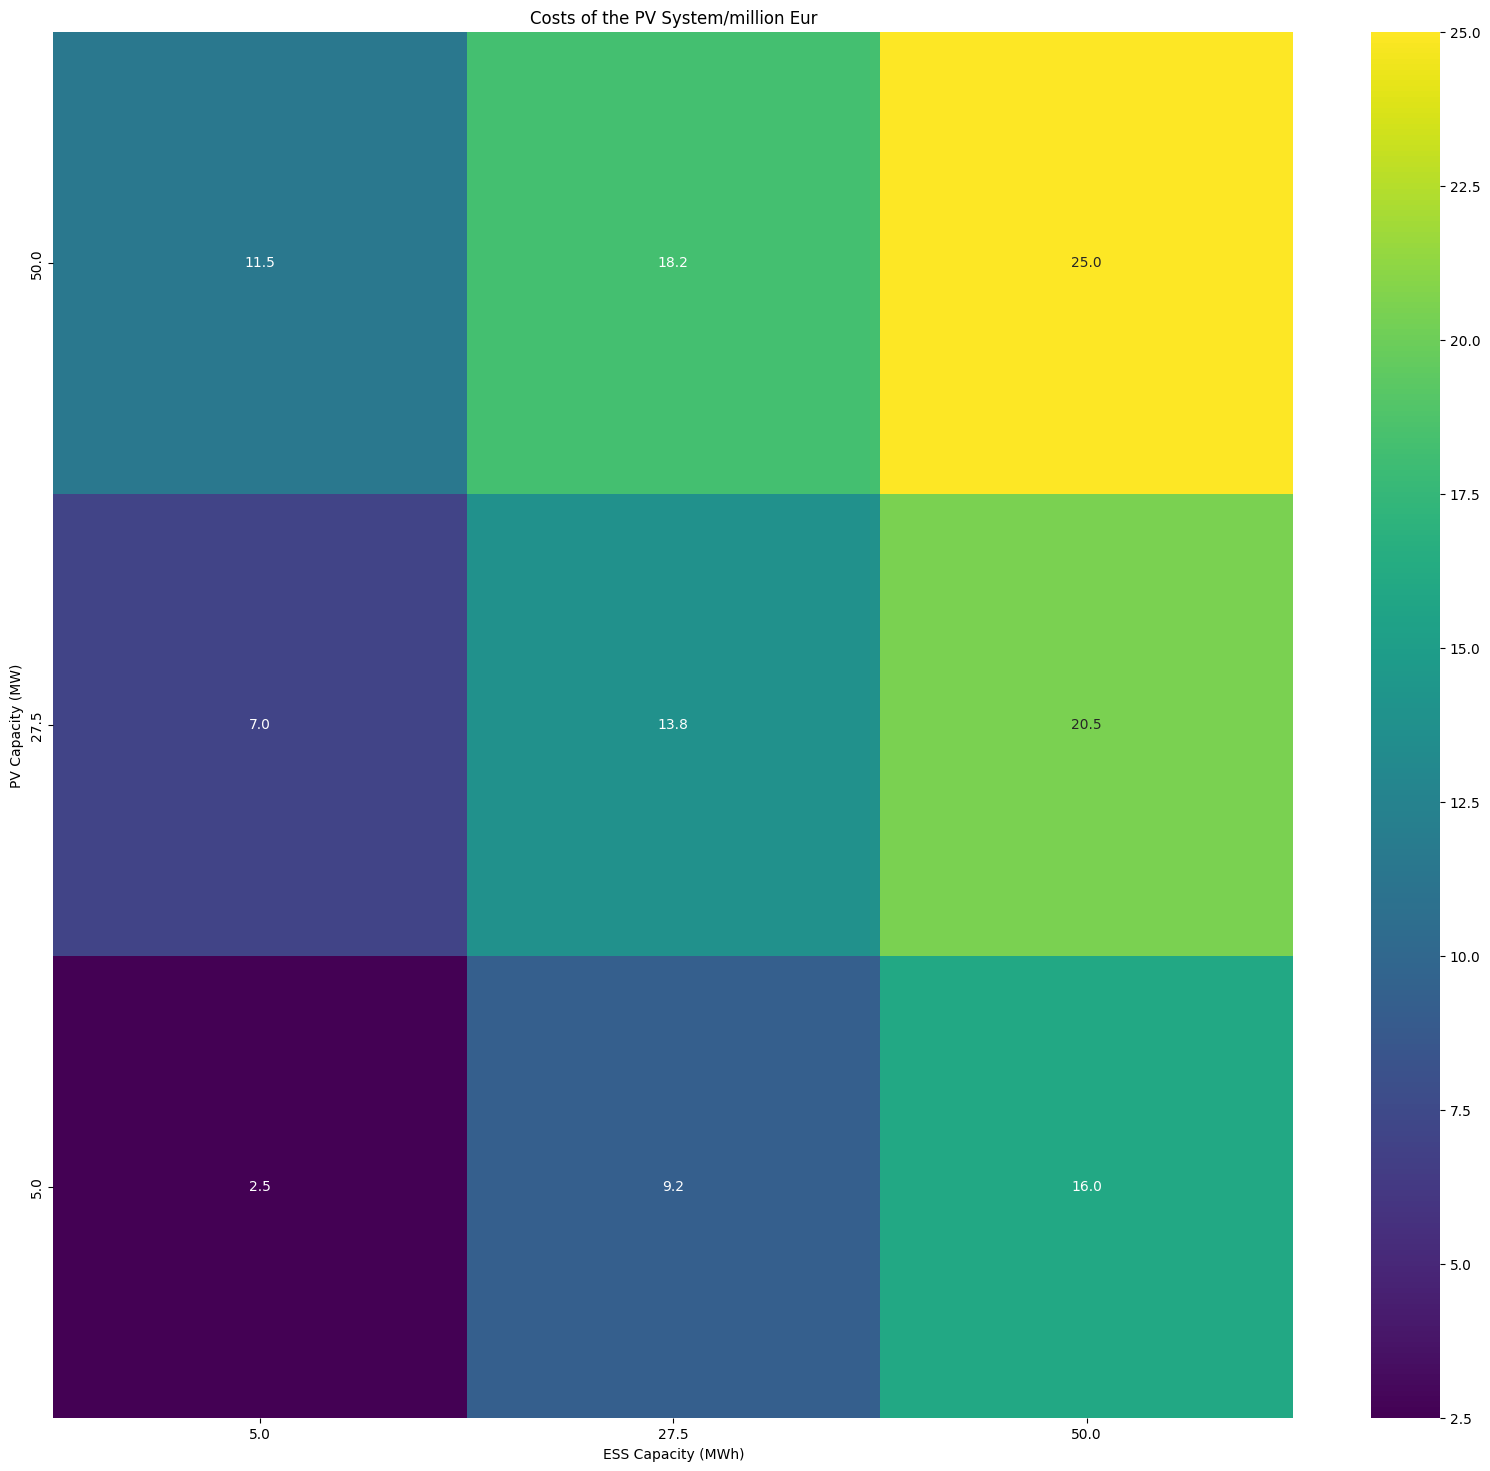

In [22]:


df = costs
df = df.astype(int)
df.index = df.index / 1000
df.columns = df.columns / 1000

plt.figure(figsize=figure_size)
sns.heatmap(df/1000000,  fmt=".1f", cmap='viridis', annot=annot_cost)
plt.title(title_cost)
plt.gca().invert_yaxis()
plt.xlabel('ESS Capacity (MWh)')
plt.ylabel('PV Capacity (MW)')
plt.savefig('plots/costs.png')

    # pv = pv_config(capacity=100000,cost_per_kW=200,lifetime=25,loss=0.95)
    # ess = ess_config(capacity=100000,cost_per_kW=300,lifetime=25,loss=0.95,charge_power=100000,discharge_power=100000)
    # grid = grid_config(price_schedule=price_schedule, capacity=5000, grid_loss=0.95, sell_price=0.4)
    # grid = grid_config(capacity=50000, grid_loss=0.95, sell_price=0.4)


    # print(benefit)

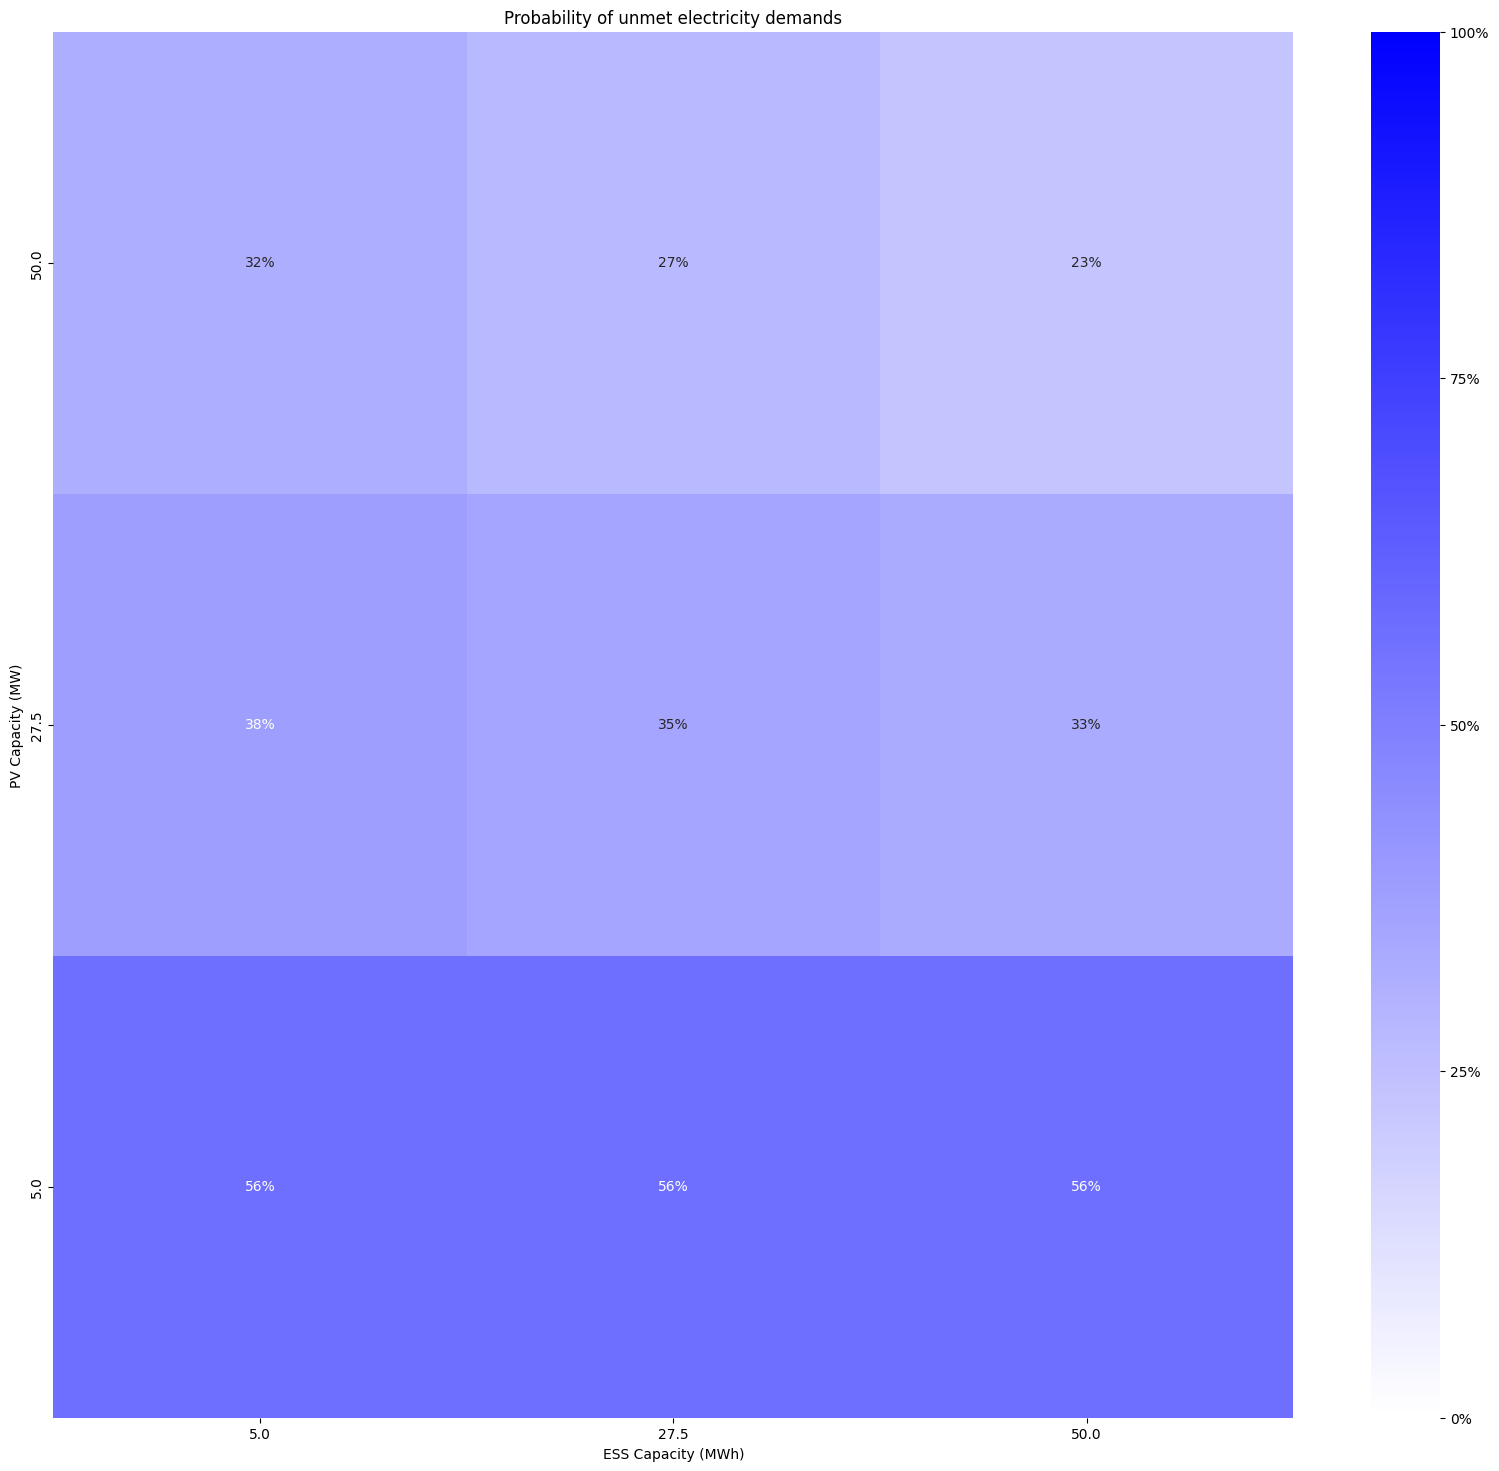

In [23]:
from matplotlib.colors import LinearSegmentedColormap
df = overload_cnt
df = df.astype(int)
df.index = df.index / 1000
df.columns = df.columns / 1000
min_value = df.min().min()
max_value = df.max().max()
max_scale = max(abs(min_value/1000), abs(max_value/1000))

plt.figure(figsize=figure_size)
cmap = LinearSegmentedColormap.from_list("", ["white", "blue"])
ax = sns.heatmap(df/(4*24*365), fmt=".00%", cmap=cmap, vmin=0, vmax=1, annot=annot_unmet)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0%}'))

plt.title(title_unmet)
plt.gca().invert_yaxis()
plt.xlabel('ESS Capacity (MWh)')
plt.ylabel('PV Capacity (MW)')
plt.savefig('plots/unmet.png')